 # Skin Cancer Full Project
 

In [ ]:
#@title Import Modules and Download Data { display-mode: "form" }
from google.colab.output import eval_js

import time
start_time = time.time()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

# import keras
from tensorflow import keras as keras

from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
from google.colab.patches import cv2_imshow
from copy import deepcopy
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet import MobileNet

!pip install hypopt
from hypopt import GridSearch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

!pip install -U opencv-contrib-python
import cv2

!pip install tensorflowjs 
import tensorflowjs as tfjs

from google.colab import files

import requests, io, zipfile

# Prepare data

DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

metadata_path = os.path.join(DATA_ROOT, 'metadata.csv')
image_path_1 = os.path.join(DATA_ROOT, 'images_1.zip')
image_path_2 = os.path.join(DATA_ROOT, 'images_2.zip')
images_rgb_path = os.path.join(DATA_ROOT, 'hmnist_8_8_RGB.csv')

!wget -O data/metadata.csv https://www.dropbox.com/s/hjmh4lhepynh3nr/metadata.csv?dl=1
!wget -O data/images_1.zip https://www.dropbox.com/s/tg6fryuhdvjpaaf/images_1.zip?dl=1
!wget -O data/images_2.zip https://www.dropbox.com/s/h2f0hlgrm2689cm/images_2.zip?dl=1
!wget -O data/hmnist_8_8_RGB.csv https://www.dropbox.com/s/mmyq9ngs0pe7lpb/hmnist_8_8_RGB.csv?dl=1

!pip install patool
import patoolib

import os.path
from os import path

if path.exists(os.path.join(DATA_ROOT, 'images_1')) == False:
  patoolib.extract_archive(os.path.join(DATA_ROOT, 'images_1.zip'), outdir= os.path.join(DATA_ROOT, 'images_1') )

if path.exists(os.path.join(DATA_ROOT, 'images_2')) == False:
  patoolib.extract_archive(os.path.join(DATA_ROOT, 'images_2.zip'), outdir= os.path.join(DATA_ROOT, 'images_2') )

from distutils.dir_util import copy_tree

fromDirectory = os.path.join(DATA_ROOT, 'images_1')
toDirectory = os.path.join(DATA_ROOT, 'images_all')

copy_tree(fromDirectory, toDirectory)

fromDirectory = os.path.join(DATA_ROOT, 'images_2')
toDirectory = os.path.join(DATA_ROOT, 'images_all')

copy_tree(fromDirectory, toDirectory)

import os
try:
  os.makedirs("static/js")
except:
  print("static/js exists")


url = 'https://drive.google.com/uc?id=1Akfbi47i0Di9i-tNoIkgIWM-yvBWHvZr'
output = 'static/js/skin_cancer_diagnosis_script.js'
gdown.download(url, output, quiet=False)

print("Downloaded Data")

In [ ]:
#@title Preprocessing of Data
IMG_WIDTH = 100
IMG_HEIGHT = 75
metadata = pd.read_csv(metadata_path)
metadata['category'] = metadata['dx'].replace({'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6,})

X = []
X_g = []

y = []

for i in tqdm(range(len(metadata))):
  image_meta = metadata.iloc[i]
  path = os.path.join(toDirectory, image_meta['image_id'] + '.jpg')
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  
  img_g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  X_g.append(img_g)

  X.append(img)
  y.append(image_meta['category'])

X_g = np.array(X_g)
X = np.array(X)
y = np.array(y)

sample_cap = 142
option = 1
#Option 1: Run this to reduce dataset size. This method caps each class at *sample_cap* samples.
if (option == 1):
  objects = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  class_totals = [0,0,0,0,0,0,0]
  iter_samples = [0,0,0,0,0,0,0]
  indicies = []

  for i in range(len(X)):
    class_totals[y[i]] += 1

  print("Initial Class Samples")
  print(class_totals)

  for i in range(len(X)):
    if iter_samples[y[i]] != sample_cap:
      indicies.append(i)
      iter_samples[y[i]] += 1

  X = X[indicies]
  X_g = X_g[indicies]

  y = y[indicies]

  class_totals = [0,0,0,0,0,0,0]

  for i in range(len(X)):
    class_totals[y[i]] += 1

  print("Modified Class Samples")
  print(class_totals)
else:
  print("This option was not selected")
#Option 2: Run this to reduce dataset size. This method only reduces the number of *nv* samples to be the same amount as the number of samples found in the second most prevalent class.
if (option == 2):
  objects = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  class_totals = [0,0,0,0,0,0,0]

  for i in range(len(X)):
    class_totals[y[i]] += 1

  print("Initial Class Samples")
  print(class_totals)

  largest_index = class_totals.index(max(class_totals))
  class_totals[largest_index] = 0

  second_largest_val = max(class_totals)

  indicies = []
  iter = 0
  for i in range(len(X)):
    if y[i] == largest_index:
      if iter != second_largest_val:
        indicies.append(i)
        iter += 1
      else:
        continue
    else:
      indicies.append(i)

  class_totals = [0,0,0,0,0,0,0]

  for i in range(len(X)):
    class_totals[y[i]] += 1

  print("Modified Class Samples")
  print(class_totals)

  X = X[indicies]
  X_g = X_g[indicies]

  y = y[indicies]
else:
  print("This option was not selected")
#Run this to Perform Data Augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
X_g_train, X_g_test, y_train, y_test = train_test_split(X_g, y, test_size=0.4, random_state=101)

X_augmented = []
X_g_augmented = []

y_augmented = []

for i in tqdm(range(len(X_train))):
  transform = random.randint(0,1)
  if (transform == 0):
    # Flip the image across the y-axis
    X_augmented.append(cv2.flip(X_train[i],1))
    X_g_augmented.append(cv2.flip(X_g_train[i],1))
    y_augmented.append(y_train[i])
  else:
    # Zoom 33% into the image
    zoom = 0.33

    centerX,centerY=int(IMG_HEIGHT/2),int(IMG_WIDTH/2)
    radiusX,radiusY= int((1-zoom)*IMG_HEIGHT*2),int((1-zoom)*IMG_WIDTH*2)

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    cropped = (X_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_augmented.append(new_img)

    cropped = (X_g_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_g_augmented.append(new_img)

    y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
X_g_augmented = np.array(X_g_augmented)

y_augmented = np.array(y_augmented)

X_train = np.vstack((X_train,X_augmented))
X_g_train = np.vstack((X_g_train,X_g_augmented))

y_train = np.append(y_train,y_augmented)

y_train_onehot = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_onehot[np.arange(y_train.size),y_train.astype(int)] = 1

y_test_onehot = np.zeros((y_test.size, y_test.max().astype(int)+1))
y_test_onehot[np.arange(y_test.size),y_test.astype(int)] = 1

In [ ]:
#@title Definition for the model_stats() and plot_cm() function
def model_stats(name, y_test, y_pred, y_pred_proba):
  cm = confusion_matrix(y_test, y_pred)

  print(name)

  accuracy = accuracy_score(y_test,y_pred)
  print ("The accuracy of the model is " + str(round(accuracy,5)))

  y_test_onehot = np.zeros((y_test.size, y_test.max().astype(int)+1))
  y_test_onehot[np.arange(y_test.size),y_test.astype(int)] = 1

  roc_score = roc_auc_score(y_test_onehot, y_pred_proba)

  print ("The ROC AUC Score of the model is " + str(round(roc_score,5)))
  
  return cm
def plot_cm(name, cm):
  classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

  df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
  df_cm = df_cm.round(5)

  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(name + " Model Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


116/116 [==============================] - 33s 129ms/step - loss: 2.9327 - auc: 0.6521 - val_loss: 1.7106 - val_auc: 0.7842
CNN
The accuracy of the model is 0.37468
The ROC AUC Score of the model is 0.79439


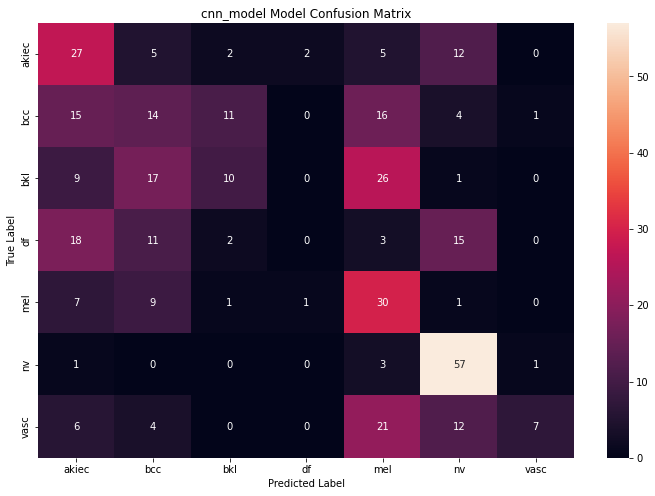

In [ ]:
#@title CNN Classifier
def CNNClassifier(epochs=1, batch_size=10, layers=5, dropout=0.5, activation='relu'):
  def set_params():
    i = 1  
  def create_model():
    model = Sequential()
    model.add(Reshape((IMG_WIDTH, IMG_HEIGHT, 3)))
    #Convolution, Activation layers number of times
    for i in range(layers):
      model.add(Conv2D(64, (3, 3), padding='same'))
      model.add(Activation(activation))
    #Conv, Activ, Max, Drop
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))
    #Conv, Activ, Conv, Activ, Max, Drop
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))
    #Flat, Dens, Activ, Drop, Dens, Activ
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=[tf.keras.metrics.AUC()])
    return model
  return KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)
cnn = CNNClassifier()
cnn.fit(X_train.astype(np.float32), y_train_onehot.astype(np.float32),
        validation_data=(X_test.astype(np.float32),y_test_onehot.astype(np.float32))
        ,verbose=1)
tfjs.converters.save_keras_model(cnn.model, 'cnn_model')
y_pred= cnn.predict(X_test)
y_pred_proba= cnn.predict_proba(X_test)
plot_cm('cnn_model', model_stats('CNN', y_test, y_pred, y_pred_proba))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


116/116 [==============================] - 16s 120ms/step - loss: 3.6720 - auc_1: 0.5645 - val_loss: 1.8334 - val_auc_1: 0.6186
CNN_Modified
The accuracy of the model is 0.16796
The ROC AUC Score of the model is 0.6976


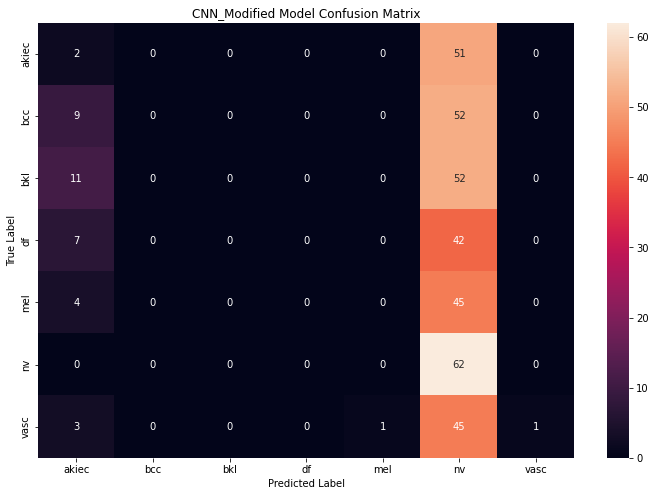

In [ ]:
#@title Modified CNN Classifier
def CNNClassifier_Modified(epochs=500, batch_size=10, layers=5, dropout=0.5, activation='relu'):
  def set_params():
    i = 1  
  def create_model():
    model = Sequential()
    model.add(Reshape((IMG_WIDTH, IMG_HEIGHT, 3)))
    for i in range(2):
      model.add(Conv2D(64, (3, 3)))
      model.add(Activation(activation))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    for i in range(3):
      model.add(Conv2D(64, (3, 3)))
      model.add(Activation(activation))
      model.add(Conv2D(64, (3, 3)))
      model.add(Activation(activation))
      model.add(Conv2D(64, (3, 3)))
      model.add(Activation(activation))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Conv2D(96, (11, 11), strides=(4,4), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(256, (5, 5), strides=(1,1), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(384, (3, 3), strides=(1,1), activation=activation))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (1, 1), strides=(1,1), activation=activation))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (1, 1), strides=(1,1), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(4096))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=[tf.keras.metrics.AUC()])
    return model
  return KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

cnnmod = CNNClassifier()
cnnmod.fit(X_train.astype(np.float32), y_train_onehot.astype(np.float32),
        validation_data=(X_test.astype(np.float32),y_test_onehot.astype(np.float32))
        ,verbose=1)
y_pred = cnnmod.predict(X_test)
y_pred_proba = cnnmod.predict_proba(X_test)
plot_cm("CNN_Modified", model_stats("CNN_Modified",y_test,y_pred,y_pred_proba))

In [ ]:
#@title Transfer Learning Preprocessing
X_test_small, X_val, y_test_small, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

y_train_onehot = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_onehot[np.arange(y_train.size),y_train.astype(int)] = 1

y_val_onehot = np.zeros((y_val.size, y_val.max().astype(int)+1))
y_val_onehot[np.arange(y_val.size),y_val.astype(int)] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


17235968/17225924 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


37/37 [==============================] - 12s 113ms/step - loss: 1.9020 - auc_2: 0.7107 - val_loss: 2.4339 - val_auc_2: 0.6071
Transfer_Learning_Model
The accuracy of the model is 0.22739
The ROC AUC Score of the model is 0.66574


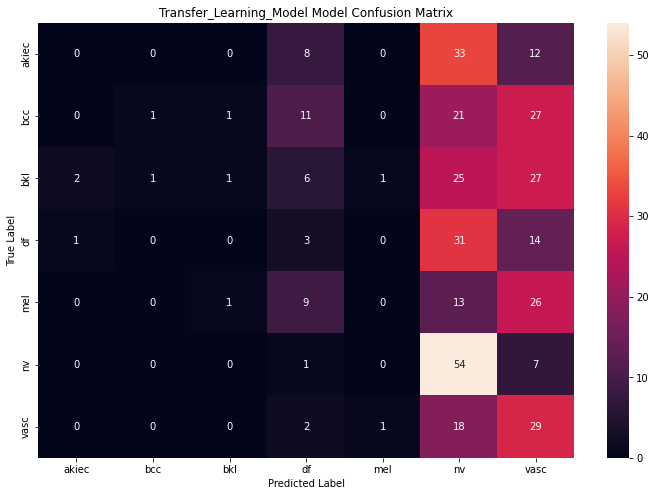

In [ ]:
#@title Transfer Learning Model
def transfer_learning_model():
  mobilenet_model = MobileNet(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, pooling="max")

  transfer_model = Sequential()
  transfer_model.add(mobilenet_model)
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(256, activation="relu"))
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(7, activation="softmax"))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  transfer_model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC()])

  return transfer_model
transfer_model = KerasClassifier(build_fn=transfer_learning_model, verbose=1,epochs=1)
transfer_model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot))
y_pred = transfer_model.predict(X_test)
y_pred_proba = transfer_model.predict_proba(X_test)
plot_cm('Transfer_Learning_Model', model_stats('Transfer_Learning_Model', y_test, y_pred, y_pred_proba))
tfjs.converters.save_keras_model(transfer_model.model, 'transfer_model')

In [ ]:
#@title Write html File
%%writefile index.html
<!DOCTYPE html>

<head>
<!-- Import Google Icon Font -->
<link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
<!-- Import CSS Stylesheet for Materialize-->
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/materialize/1.0.0/css/materialize.min.css">
<!--Optimize Viewport for Mobile Devices-->
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>

</head>

<body class= "blue lighten-4">
<!-- Title Bar -->

<nav class="blue lighten-2">
    <div class="center-align" style= "padding:0%">
      <a href="#" class="brand-logo">Skin Lesion Diagnosis</a>
    </div>
  </nav>
<!-- Container for all other HTML Elements -->
<div style="padding:5%">

<!-- Loading Bar --> 
<h4 id="loadingmodel" style="font-size:175%; color:rgb(13, 71, 161)"><b>Loading ML Model<b></h4>
<div id="progressbar" class="progress light-blue accent-2">
    <div class="indeterminate light-blue accent-4"></div>
</div>

<!-- Image File Input -->
<div class="file-field input-field">
    <div class="waves-effect waves-light btn blue lighten-2">
      <span>Select Image</span>
      <input type="file" accept="image/*" onchange="onFileSelected(event)">
    </div>
    <div class="file-path-wrapper">
      <input class="file-path validate" type="text">
    </div>
  </div>

<!-- Image to be Classified -->
<img id="image" width=100 height=75></img>
<!-- Add New Lines -->
<br/>

<!-- Button to Perform Classification -->
<a onclick="predict()" class="blue lighten-2 waves-effect waves-light btn"><i class="left material-icons">add_alert</i>Classify Image</a>

<!-- Text Fields for the Prediction -->
<h3 style="font-size:175%; color:rgb(13, 71, 161)"><b>Prediction</b></h3>
<b><p id="prediction"></p></b>
<b><p id="probability"></p></b>

<!-- Import JS Libraries -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/materialize/1.0.0/js/materialize.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.0.0/dist/tf.min.js"></script>

<!-- Background JS -->
<script>
var model = null

var classes = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratoses', 'Dermatofibroma', 'Melanoma', 'Melanocytic Nevus', 'Vascular Lesion']

// Function to perform prediction on our Tensorflow JS Model

async function predict(){

    try {
        if(imgtag.src == ""){
            alert("Select an Image to Classify")
            return
        }

        let tensorImg = tf.browser.fromPixels(imgtag)
                        .resizeNearestNeighbor([75, 100])
                        .toFloat().expandDims();
        
        model.predict(tensorImg).data().then(
    function (prediction){
        let predicted_class = prediction.indexOf(Math.max(...prediction))


        console.log(classes[predicted_class])
        console.log(prediction) 

        prediction_text.innerHTML = classes[predicted_class]
        <!-- probability_text.innerHTML = Math.round(prediction[predicted_class] * 100) + "% Confidence" -->
    }
)
        
    }catch(error){
        alert("Error Classifying Image")
    }
}

// Function to Select our Image and Display it

function onFileSelected(event) {

    try {
        var selectedFile = event.target.files[0];
        var reader = new FileReader();

        imgtag.title = selectedFile.name;

        reader.onload = function(event) {
          imgtag.src = event.target.result;         
        
        };

        reader.readAsDataURL(selectedFile);
    }catch (error){
        alert("Error Reading Image")
    }
    
}

// Function to Select our Image and Display it

async function loadModel(){
    console.log("Loading Model")
    model = await tf.loadLayersModel('cnn_model/model.json')    
    console.log("Loaded Model")

    loadingmodel.innerHTML = "Loaded ML Model"
    progressbar.style.display = "none"
}

loadModel()

</script>

<script>
    // Initialize our HTML elements as JS objects
    var imgtag = document.getElementById("image")
    var prediction_text = document.getElementById("prediction")
    var probability_text = document.getElementById("probability")
    var progressbar = document.getElementById("progressbar")
    var loadingmodel = document.getElementById("loadingmodel")    
</script>

</div>

</body>

</html>

Overwriting index.html


In [ ]:
#@title Host Website
print(eval_js("google.colab.kernel.proxyPort(8000)"))
!python -m http.server 8000

https://xrcqohkliop-496ff2e9c6d22116-8000-colab.googleusercontent.com/
Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET /cnn_model/model.json HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:32] code 404, message File not found
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET /cnn_model/group1-shard1of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET /cnn_model/group1-shard17of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:32] "GET /cnn_model/group1-shard2of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:33] "GET /cnn_model/group1-shard9of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:33] "GET /cnn_model/group1-shard3of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:33] "GET /cnn_model/group1-shard6of25.bin HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2022 02:39:33] "GE

Important Links for Website Building

https://www.w3schools.com/tryit/tryit.asp?filename=tryhtml_default

https://materializecss.com/color.html

https://materializecss.com/icons.html

https://materializecss.com/helpers.html

